*Authors:* Ismael Mendoza, Andrii Torchylo

In this tutorial, we go through some of the additional features available in the `metrics` module of btk.

*Outline*:

- Showcase one of each of the types of metrics, explain inputs/outputs
- Show how to create your own custom metric, specifically an F1 Score metric (which is not yet implemented)
- the two different matching algorithms and what the inputs/outputs are, brief description of each and their arguments
- Each of the measure functions and expected input, histogram for one or two of them

# Setup 

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import galsim

In [ ]:
import btk
import btk.survey
import btk.draw_blends
import btk.catalog
import btk.sampling_functions

# Generate some data

Let's generate some data with BTK that we can use to test the different aspects of the `metrics` module.

In [ ]:
from btk.sampling_functions import DefaultSampling
from btk.catalog import CatsimCatalog
from btk.survey import get_surveys
from btk.survey import Survey
from btk.draw_blends import CatsimGenerator
from btk.deblend import SepSingleBand

catalog_file = "../data/input_catalog.fits"
catalog = CatsimCatalog.from_file(catalog_file)

_ = catalog.get_raw_catalog()

survey: Survey = get_surveys("LSST")

stamp_size = 24.0
max_shift = 3.0
max_n_sources = 7
sampling_function = DefaultSampling(
    max_number=max_n_sources,
    min_number=1,
    stamp_size=stamp_size,
    max_shift=max_shift,
    max_mag=25.3,
    seed=0,
)

batch_size = 10

draw_generator = CatsimGenerator(
    catalog,
    sampling_function,
    survey,
    batch_size=batch_size,
    stamp_size=stamp_size,
    njobs=1,
    add_noise="all",
    seed=0,
)

# generate batch 100 blend catalogs and images.
blend_batch = next(draw_generator)

# deblend with SEP to get predictions
deblender = SepSingleBand(
    max_n_sources=max_n_sources,  # same as above
    thresh=3,  # threshold pixel value for detection (see SEP docs)
    use_band=2,  # measure on 'r' band
)
deblend_batch = deblender(blend_batch, njobs=1)

In [ ]:
# examine output
blend_batch, deblend_batch

(BlendBatch(survey_name=LSST, 
 	 blend_images: np.ndarray, shape [10, 6, 120, 120]
 	 isolated_images: np.ndarray, shape [10, 7, 6, 120, 120]
 	 catalog_list: list of <class 'astropy.table.table.Table'>, size 10
 	 psfs: list of <class 'galsim.gsobject.GSObject'>, size 6
 	 wcs: <class 'astropy.wcs.wcs.WCS'>),
 DeblendBatch(batch_size = 10, max_n_sources = 7 n_bands = 1, image_size = 120), containing: 
 	catalog_list: list of <class 'astropy.table.table.Table'>, size 10
 	segmentation: <class 'numpy.ndarray'>, shape [10, 7, 120, 120]
 	deblended_images: <class 'numpy.ndarray'>, shape [10, 7, 1, 120, 120])

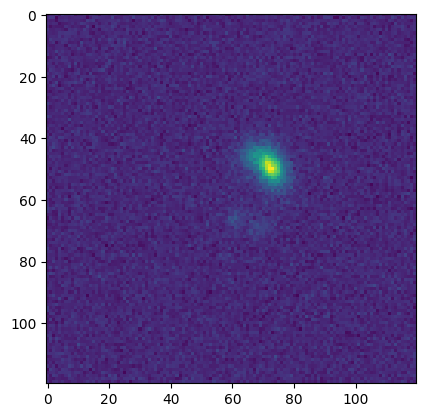

In [ ]:
# example blends
plt.imshow(blend_batch.blend_images[0, 0])

# Metrics

In BTK, we have three types of available metrics. The detection, segmentation, and reconstruction metrics. Each of them is available in its corresponding module:

In [ ]:
import btk.metrics.detection
import btk.metrics.segmentation
import btk.metrics.reconstruction

Let's talk first about the detection metrics, which were also mentioned in the quickstart tutorial notebooks. The metrics currently available include: 

- `Precision`
- `Recall` 
- `F1` 
- `Efficiency`

All of these metrics are subclass implementations of the same parent class `btk.metrics.detection.DetectionMetric`. In particular, these metrics all take three arrays as input `n_matches`, `n_true`, and `n_pred` where: 

- `n_matches`: An array where each element is the number of true positives matches for a given galaxy blend. 
- `n_true`: An array where each element is the number of galaxies for a given galaxy blend.
 - `n_pred`: An array where each element is the number of detections for a given galaxy blend.

 These three arrays are readily accessible from the output of the matcher as demonstrated below:

In [ ]:
from btk.match import PixelHungarianMatcher
from btk.metrics.detection import Recall, Precision

# create matcher
matcher = PixelHungarianMatcher(pixel_max_sep=5.0)

# get matching from the true and detections catalog
match = matcher(blend_batch.catalog_list, deblend_batch.catalog_list)

# compute precision and recall using the attributes of the matching
recall = Recall(match.batch_size)
precision = Precision(match.batch_size)
recall(match.tp, match.t, match.p), precision(match.tp, match.t, match.p)

(0.5365853658536586, 1.0)

Next, the segmentation metrics include only the `IoU` metric which can only be applied to the deblenders that output segmentation as part of their output. The `SepSingleBand` deblender does output segmentation information so we demonstrate its usage below with this output.

An important additional step compared to the detection metrics is that we need to apply the obtained matching to the arrays of images that we want to calculate the metric with. In this case, we need to apply it to the segmentation arrays. Note that there is no a priori segmentations for the true images, so we obtain them using the `btk.metrics.utils.get_segmentations` function which creates arrays corresponding to each individual galaxy image where each pixel gets turned to either `0` or `1` depending on whether that pixel is above the noise level of the image. Below is an example usage and image: 

In [ ]:
from btk.metrics.utils import get_segmentation
from galcheat.utilities import mean_sky_level

sky_level = mean_sky_level('LSST', 'r').to_value('electron') # gain = 1
true_segs = get_segmentation(blend_batch.isolated_images[:, :, 2], sky_level, sigma_noise=3)
true_segs.shape

(10, 7, 120, 120)

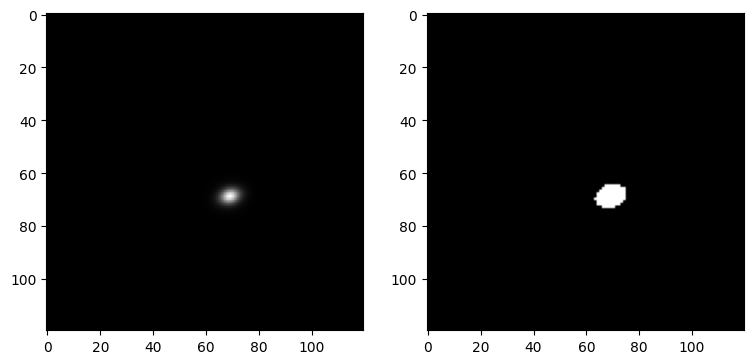

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))

ax1.imshow(blend_batch.isolated_images[0, 0, 2], cmap='gray')
ax2.imshow(true_segs[0, 0], cmap='gray')

Now we match the corresponding arrays using the method `match_true_arrays` and `match_pred_arrays` from the output `match` from running the `matcher` above: 

In [ ]:
segs1 = match.match_true_arrays(true_segs)
segs2 = match.match_pred_arrays(deblend_batch.segmentation)
segs1.shape, segs2.shape

((10, 3, 120, 120), (10, 3, 120, 120))

Now we can apply our segmentation metrics on these matched segmentations:

In [ ]:
from btk.metrics.segmentation import IoU

iou = IoU(match.batch_size)
iou(segs1, segs2)

0.7695449983946172

# Measure Functions

# Matching